## Model Evaluation & Analysis
Here we evaluate the final Decision Tree model, compare it with Random Forest and Categorical NB, and reflect on strengths, limitations, and potential risks.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import joblib

In [2]:
X_train = joblib.load('models/X_train_final.pkl')
X_test = joblib.load('models/X_test_final.pkl')
y_train = joblib.load('models/y_train_encoded.pkl')
y_test = joblib.load('models/y_test_encoded.pkl')

Re-training Decision Tree with Best Params

In [7]:
dt_params = {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
final_model = DecisionTreeClassifier(random_state=42, **dt_params)
final_model.fit(X_train, y_train)

y_pred_dt = final_model.predict(X_test)

In [13]:
# this is for api
joblib.dump(final_model, "models/dt_model.pkl")

['models/dt_model.pkl']

In [10]:
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='accuracy')
print("Decision Tree Cross-Validation Accuracy (5-fold):")
print(f"Mean: {cv_scores.mean():.4f}")
print(f"Std: {cv_scores.std():.4f}")

Decision Tree Cross-Validation Accuracy (5-fold):
Mean: 1.0000
Std: 0.0000


Model Evaluation and Visualization


--- Classification Report (Final Model: Decision Tree) ---
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       842
     Class 1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


--- Confusion Matrix ---


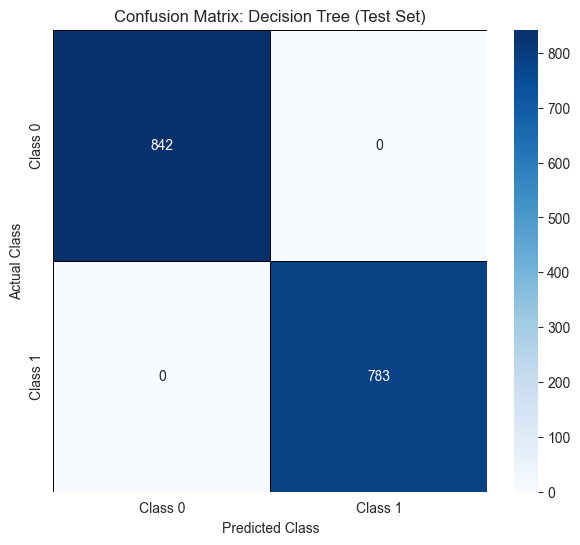

In [4]:
print("\n--- Classification Report (Final Model: Decision Tree) ---")
TARGET_NAMES = ['Class 0', 'Class 1']
print(classification_report(y_test, y_pred_dt, target_names=TARGET_NAMES))

print("\n--- Confusion Matrix ---")

cm = confusion_matrix(y_test, y_pred_dt)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES,
            linewidths=.5, linecolor='black')
plt.title('Decision Tree Confusion Matrix (Percentages)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


--- Feature Importance Plot ---


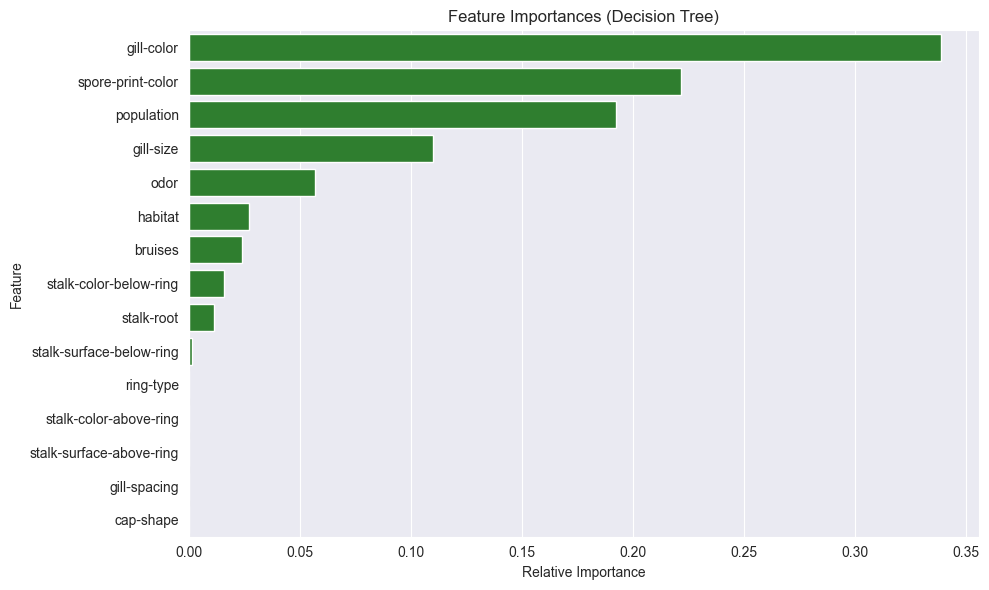

In [12]:
print("\n--- Feature Importance Plot ---")

importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='forestgreen')
plt.title('Feature Importances (Decision Tree)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

 **1) Decision Tree (DT)**
<br><br> **STRENGTH:** It's the simplest model. Achieved 100% accuracy with clear, transparent rules. Low computing power needed.
<br> **WEAKNESS:** The perfect 100% score suggests the model might be too tuned to this data, risking failure on new, slightly different real-world data.
<br><br> **2) Random Forest (RF)**
<br><br> **STRENGTH:** As a group of trees, it's generally a very stable and dependable model that handles data noise well.
<br> **WEAKNESS:** Does not perform better than the DT, but is harder to explain and uses more computing power. We reject it because it's unnecessarily complicated.
<br><br> **3) Categorical NB**
<br><br> **STRENGTH:** Quickest model to train, making it a good starting point.
<br> **WEAKNESS:** It failed because it assumes features don't influence each other, which is not true for real-world data. Also, its performance is lower than other models have (≈96%). Also, if new feature appears in test data, the model will assign zero probability so we'll need to apply smoothing to ensure that our mushrooms with new ring type are recognized.

**Overall Reflection**
- Cross-validation shows consistent DT performance
- Confusion matrix confirms no misclassifications
- Feature importance highlights key drivers (e.g., 'odor', 'spore-print-color')
- Limitation: perfect accuracy could mask overfitting; monitor real-world deployment
- Fairness & bias: not critical here, but ensure generalizability for new data